<a href="https://colab.research.google.com/github/Dain777666/ESAA_25-2/blob/main/OB_WEEK12_MON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 5.2 합성곱 신경망 맛보기

< fashion_mnist 데이터셋 >

- 운동화, 셔츠, 샌들 같은 작은 이미지의 모음

- 열 가지로 분류될 수 있는 28X28 픽셀의 이미지 7만개로 구성되어 있음

- 훈련 데이터: 0~255 사이의 값을 가짐

- 레이블 데이터: 0~9까지의 정수 값을 가짐

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
train_dataset=torchvision.datasets.FashionMNIST('./content', download=True,
                                                transform=transforms.Compose([transforms.ToTensor()]))
test_dataset=torchvision.datasets.FashionMNIST('./content', download=True,
                                                train=False, transform=transforms.Compose([transforms.ToTensor()]))


100%|██████████| 26.4M/26.4M [00:01<00:00, 19.1MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 332kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.67MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 20.6MB/s]


- transform.ToTensor(): 이미지를 텐서로 변경함

In [4]:
train_loader=torch.utils.data.DataLoader(train_dataset,
                                         batch_size=100)
test_loader=torch.utils.data.DataLoader(test_dataset,
                                        batch_size=100)

- torch.utils.data.DataLoader(): 원하는 크기의 배치 단위로 데이터를 불러오거
나，순서가 무작위로 섞이도록(shuffle) 함

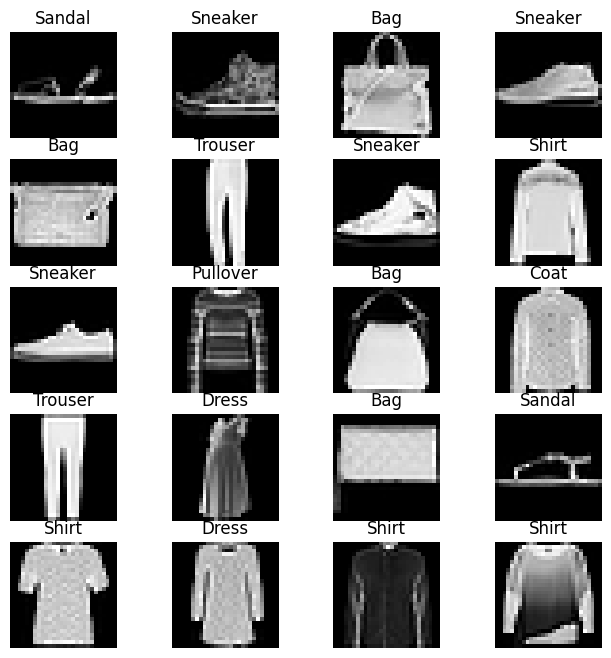

In [5]:
labels_map={0:'T-Shirt', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat',
            5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle Boot'}

fig=plt.figure(figsize=(8,8))
columns=4
rows=5
for i in range(1, columns*rows+1):
    img_xy=np.random.randint(len(train_dataset))
    img=train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

In [6]:
# 심층 신경망 모델 생성

class FashionDNN(nn.Module):
    def __init__(self):
        super(FashionDNN, self).__init__()
        self.fc1=nn.Linear(in_features=784, out_features=256)
        self.drop=nn.Dropout(0.25)
        self.fc2=nn.Linear(in_features=256, out_features=128)
        self.fc3=nn.Linear(in_features=128, out_features=10)

    def forward(self, input_data):
        out=input_data.view(-1, 784)
        out=F.relu(self.fc1(out))
        out=self.drop(out)
        out=F.relu(self.fc2(out))
        out=self.fc3(out)
        return out

- class 형태의 모델은 항상 torch.nn.Module을 상속받음

- __ init __()은 객체가 갖는 속성 값을 초기화하는 역할, 객체가 생성될 때 자동으로 호출됨

- super(FashionDNN, self).__ init __()은 nn.Module 클래스를 상속받음

- nn은 딥러닝 모델 구성에 필요한 모듈이 모여 있는 패키지

- forward()는 모델이 학습 데이터를 입력받아서 순전파 학습을 진행시킴

- view()는 reshape의 역할로 텐서의 크기를 변경해주는 역할

< 활성화 함수 지정 >

1. F.relu(): forward()함수에서 정의

2. nn.Relu(): __ init __() 함수에서 정의

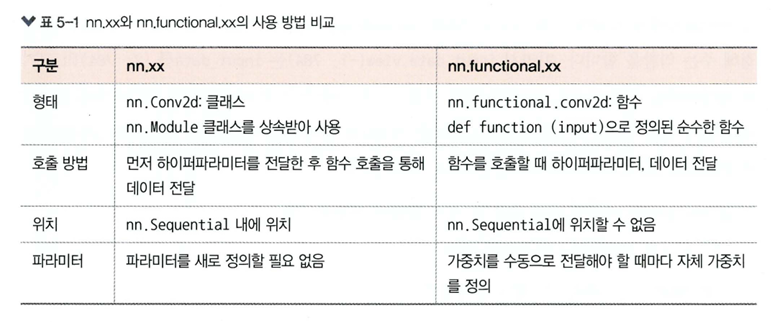

In [7]:
learning_rate=0.001
model=FashionDNN()
model.to(device)

criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [8]:
num_epochs=5
count=0
loss_list=[]
iteration_list=[]
accuracy_list=[]

predictions_list=[]
labels_list=[]

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels=images.to(device), labels.to(device)

        train=Variable(images.view(100,1,28,28))
        labels=Variable(labels)

        outputs=model(train)
        loss=criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count+=1

        if not (count % 50):
            total=0
            correct=0
            for images, labels in test_loader:
                images, labels=images.to(device), labels.to(device)
                labels_list.append(labels)
                test=Variable(images.view(100,1,28,28))
                outputs=model(test)
                predictions=torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct+= (predictions==labels).sum()
                total+=len(labels)

            accuracy=correct*100/total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print('Iteration: {}, Loss: {}, Accuracy: {}%'.format(count, loss.data, accuracy))

Iteration: 500, Loss: 0.5858941674232483, Accuracy: 83.19000244140625%
Iteration: 1000, Loss: 0.4620998501777649, Accuracy: 84.36000061035156%
Iteration: 1500, Loss: 0.39088600873947144, Accuracy: 85.16999816894531%
Iteration: 2000, Loss: 0.3837343156337738, Accuracy: 85.33000183105469%
Iteration: 2500, Loss: 0.28333839774131775, Accuracy: 85.98999786376953%
Iteration: 3000, Loss: 0.2745087742805481, Accuracy: 87.04000091552734%


- 모댈이 데이터를 처리하기 위해서는 모댈과 데이터가 동일한 장치(CPU 또는 GPU)에 있어야 함

- Autograd는 자동 미분을 수행하는 파이토치의 핵심 패키지로，자동 미분에 대한 값을 저장하기 위해 테이프(tape)를 사용함 -> 순전파 단계에서 태이프는 수행하는 모든 연산을 저장함 ->  역전파 단계에서 저장된 값들을 꺼내서 사용함

In [9]:
# 합성곱 네트워크 생성

class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.layer1=nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2=nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1=nn.Linear(in_features=64*6*6, out_features=600)
        self.drop=nn.Dropout2d(0.25)
        self.fc2=nn.Linear(in_features=600, out_features=120)
        self.fc3=nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        out=self.layer1(x)
        out=self.layer2(out)
        out=out.view(out.size(0),-1)
        out=self.fc1(out)
        out=self.drop(out)
        out=self.fc2(out)
        out=self.fc3(out)
        return out

- nn.Sequential을 사용하면 __ init __()에서 사용할 네트워크 모델들을 정의해 줄 뿐만 아니라, forward() 함수에서 구현될 순전파를 계층 형태로 좀 더 가독성이 뛰어난 코드로 작성할 수 있음

- 합성곱층은 이미지의 특징을 추출함

```
nn.Conv2d(in_channels=1, out channels=32, kernel size=3, padding=1)
```

- BatchNorm2d는 학습 과정에서 각 배치 단위별로 데이터가 다양한 분포를 가지더라도 평균과 분산을 이용하여 정규화하는 것

- MaxPool2d는 이미지 크기를 축소시키는 용도로 사용함

- 클래스를 분류하기 위해서는 이미지 형태의 데이터를 배열 형태로 변환하여 작업해야함


In [10]:
learning_rate=0.001
model=FashionCNN()
model.to(device)

criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [11]:
num_epochs=5
count=0
loss_list=[]
iteration_list=[]
accuracy_list=[]

predictions_list=[]
labels_list=[]

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels=images.to(device), labels.to(device)

        train=Variable(images.view(100,1,28,28))
        labels=Variable(labels)

        outputs=model(train)
        loss=criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count+=1

        if not (count % 50):
            total=0
            correct=0
            for images, labels in test_loader:
                images, labels=images.to(device), labels.to(device)
                labels_list.append(labels)
                test=Variable(images.view(100,1,28,28))
                outputs=model(test)
                predictions=torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct+= (predictions==labels).sum()
                total+=len(labels)

            accuracy=correct*100/total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print('Iteration: {}, Loss: {}, Accuracy: {}%'.format(count, loss.data, accuracy))

/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:1535: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration: 500, Loss: 0.49535325169563293, Accuracy: 88.19999694824219%
Iteration: 1000, Loss: 0.33311721682548523, Accuracy: 88.6500015258789%
Iteration: 1500, Loss: 0.25893643498420715, Accuracy: 87.62999725341797%
Iteration: 2000, Loss: 0.21752464771270752, Accuracy: 89.19000244140625%
Iteration: 2500, Loss: 0.17125172913074493, Accuracy: 90.02999877929688%
Iteration: 3000, Loss: 0.1639929562807083, Accuracy: 90.52999877929688%
